# Convolutional Neural Networks

## Project: Write an Algorithm for Landmark Classification


### Introduction

The project folder has the following structure:

* In the main directory you have this notebook, `cnn_from_scratch.ipynb`, that contains the instruction and some questions you will have to answer. Follow this notebook and complete the required sections in order.

* In the `src/` directory you have several source files. As instructed in this notebook, you will open and complete those files, then come back to this notebook to execute some tests that will verify what you have done. While these tests don't guarantee that your work is bug-free, they will help you finding the most obvious problems so you will be able to proceed to the next step with confidence.

* Sometimes you will need to restart the notebook. If you do so, remember to execute also the cells containing the code you have already completed starting from the top, before you move on.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

> <img src="static_images/icons/noun-info-2558213.png" alt="?" style="width:25px"/> Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.

### Designing and training a CNN from scratch

In this notebook, you will create a CNN that classifies landmarks.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 50%.

Although 50% may seem low at first glance, it seems more reasonable after realizing how difficult of a problem this is. Many times, an image that is taken at a landmark captures a fairly mundane image of an animal or plant, like in the following picture.

<img src="static_images/train/00.Haleakala_National_Park/084c2aa50d0a9249.jpg" alt="Bird in Haleakalā National Park" style="width: 400px;"/>

Just by looking at that image alone, would you have been able to guess that it was taken at the Haleakalā National Park in Hawaii?

An accuracy of 50% is significantly better than random guessing, which would provide an accuracy of just 2% (100% / 50 classes). In Step 2 of this notebook, you will have the opportunity to greatly improve accuracy by using transfer learning to create a CNN.

Experiment with different architectures, hyperparameters, training strategies, and trust your intuition.  And, of course, have fun!

---
## <img src="static_images/icons/noun-advance-2109145.png" alt=">" style="width:50px"/> : Setting up

The following cells make sure that your environment is setup correctly, download the data if you don't have it already, and also check that your GPU is available and ready to go. You have to execute them every time you restart your notebook.

In [1]:
from src.helpers import setup_env

# If running locally, this will download dataset (make sure you have at 
# least 2 Gb of space on your hard drive)
setup_env()

GPU *NOT* available. Will use CPU (slow)
Dataset already downloaded. If you need to re-download, please delete the directory landmark_images
Reusing cached mean and std


<img src="static_images/icons/noun-question-mark-869751.png" alt="?" style="width:25px"/> **Question:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?

**Answer**: My code first resizes the image to 256 and then crops to 224. I picked 224 as the input size because it is the recommended input size for using pytorch's pre-trained models. I did decide to augment the dataset via RandAugment, a typical set of augmentations for natural images. I added this augmentation with the goal of improving my model's robustness, thus improving test accuracy.

We can now use the code we just completed to get a batch of images from your train data loader and look at them.

Visualizing the output of your data loader is a great way to ensure that your data loading and preprocessing (including transforms such as rotations, translations, color transforms...) are working as expected.

Reusing cached mean and std
Dataset mean: tensor([0.4638, 0.4725, 0.4687]), std: tensor([0.2697, 0.2706, 0.3017])
Reusing cached mean and std


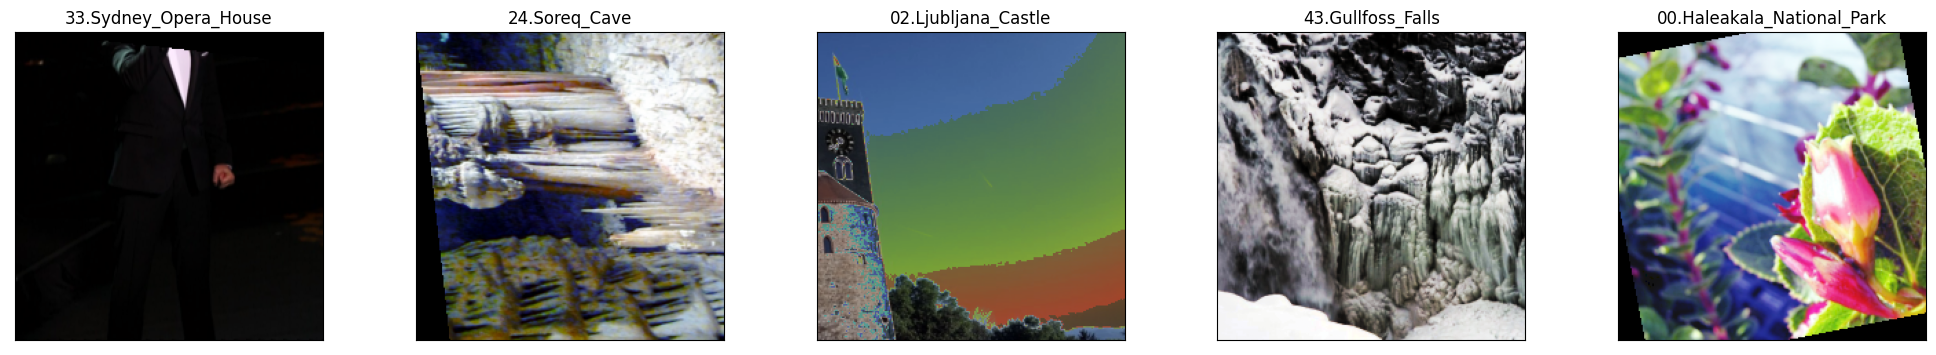

In [4]:
#%matplotlib inline
from src.data import visualize_one_batch, get_data_loaders

# use get_data_loaders to get the data_loaders dictionary. Use a batch_size
# of 5, a validation size of 0.01 and num_workers=-1 (all CPUs)
data_loaders = get_data_loaders(batch_size=5, valid_size=0.01)

visualize_one_batch(data_loaders)

---
## <img src="static_images/icons/noun-advance-2109145.png" alt=">" style="width:50px"/> Step 5: Putting everything together

Allright, good job getting here! Now it's time to see if all our hard work pays off. In the following cell we will train your model and validate it against the validation set.

Let's start by defining a few hyperparameters. Feel free to experiment with different values and try to optimize your model:

In [5]:
batch_size = 64        # size of the minibatch for stochastic gradient descent (or Adam)
valid_size = 0.2       # fraction of the training data to reserve for validation
num_epochs = 100        # number of epochs for training
num_classes = 50       # number of classes. Do not change this
dropout = 0.5          # dropout for our model
learning_rate = 0.01  # Learning rate for SGD (or Adam)
opt = 'adam'            # optimizer. 'sgd' or 'adam'
weight_decay = 0.0001     # regularization. Increase this to combat overfitting

In [3]:
from src.data import get_data_loaders
from src.train import optimize
from src.optimization import get_optimizer, get_loss
from src.model import MyModel

data_loaders = get_data_loaders(batch_size=1)
images, labels = next(iter(data_loaders['train']))
print('images.shape : ', images.shape)
model = MyModel(50, 0.2)
print(model)
out = model(images)
out.shape

Reusing cached mean and std
Dataset mean: tensor([0.4638, 0.4725, 0.4687]), std: tensor([0.2697, 0.2706, 0.3017])
images.shape :  torch.Size([1, 3, 224, 224])
MyModel(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (dropout2d): Dropout2d(p=0.2, inplace=False)
  (layer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Dropout2d(p=0.2, inplace=False)
  )
  (layer2): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=Fals

torch.Size([1, 50])

In [13]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

6695666

In [6]:
from src.data import get_data_loaders
from src.train import optimize
from src.optimization import get_optimizer, get_loss
from src.model import MyModel

# get the data loaders using batch_size and valid_size defined in the previous
# cell
# HINT: do NOT copy/paste the values. Use the variables instead
data_loaders = get_data_loaders(
    batch_size=batch_size,
    valid_size=valid_size    
)

# instance model MyModel with num_classes and drouput defined in the previous
# cell
model = MyModel(num_classes=num_classes, dropout=dropout)

# Get the optimizer using get_optimizer and the model you just created, the learning rate,
# the optimizer and the weight decay specified in the previous cell
optimizer = get_optimizer(
    model=model,
    optimizer=opt,
    learning_rate=learning_rate,
)

# Get the loss using get_loss
loss = get_loss()

#optimize(
    #data_loaders,
    #model,
    #optimizer,
    #loss,
   # n_epochs=num_epochs,
   # save_path="checkpoints/best_val_loss.pt",
    #interactive_tracking=True
#)

Reusing cached mean and std
Dataset mean: tensor([0.4638, 0.4725, 0.4687]), std: tensor([0.2697, 0.2706, 0.3017])


---
## <img src="static_images/icons/noun-advance-2109145.png" alt=">" style="width:50px"/> Step 6: testing against the Test Set

> <img src="static_images/icons/noun-info-2558213.png" alt="?" style="width:25px"/> only run this *after* you have completed hyperpameter optimization. Do not optimize hyperparameters by looking at the results on the test set, or you might overfit on the test set (bad, bad, bad)

Run the code cell below to try out your model on the test dataset of landmark images. Ensure that your test accuracy is greater than 50%.

In [3]:
# load the model that got the best validation accuracy
from src.train import one_epoch_test
from src.model import MyModel
import torch

model = MyModel(num_classes=num_classes, dropout=dropout)

# YOUR CODE HERE: load the weights in 'checkpoints/best_val_loss.pt'
model.load_state_dict(torch.load(map_location=torch.device('cpu'), f='checkpoints/best_val_loss.pt'))

# Run test
one_epoch_test(data_loaders['test'], model, loss)

Testing: 100%|██████████████████████████████████| 20/20 [00:27<00:00,  1.40s/it]

Test Loss: 1.321530


Test Accuracy: 67% (845/1250)


1.32153040766716

In [13]:
# for netron visualize model
random_image = torch.rand((1, 3, 400, 1520))
scripted = torch.jit.trace(model, random_image)
torch.jit.save(scripted, "checkpoints/my_network_for_NETRON.pt")

Learning Rate Finder

Reusing cached mean and std
Dataset mean: tensor([0.4638, 0.4725, 0.4687]), std: tensor([0.2697, 0.2706, 0.3017])


Training:  98%|████████████████████████████████▍| 62/63 [08:35<00:08,  8.32s/it]


(1.3669351637363434, 1.6820540574175662)

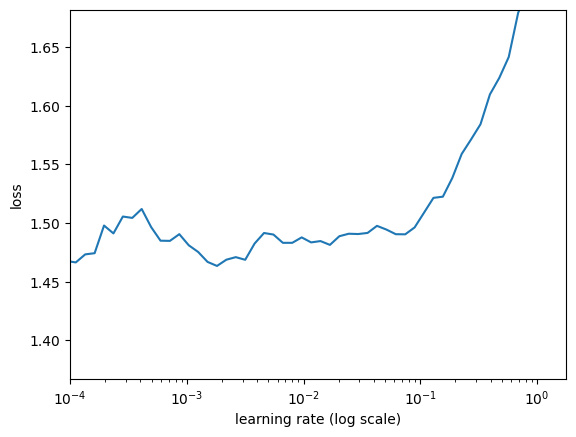

In [6]:
#Learning Rate Finder
# Feel free to look into the code of lr_finder and see how it works!
import matplotlib.pyplot as plt
import torch.nn as nn
import numpy as np
from src.lr_finder import lr_finder

batch_size = 64
valid_size = 0.2
num_workers = 0 #multiprocessing.cpu_count() crushes kernel when this ????


data_loaders = get_data_loaders(
    batch_size=batch_size,
    valid_size=valid_size    
)

# Range  and number of steps for the learning rate
min_lr = 1e-5 # 0.00001
max_lr = 1
n_steps = min(len(data_loaders['train']), 100)

# specify loss function (categorical cross-entropy)
loss = nn.CrossEntropyLoss()

losses = lr_finder(min_lr, max_lr, n_steps, loss, model, data_loaders)

# Plot the results
plt.plot(losses.keys(), losses.values())
plt.xscale("log")
plt.ylabel("loss")
plt.xlabel("learning rate (log scale)")

# Adjust the range on the y-axis to see things more clearly
plt.xlim([1e-4, None])
plt.ylim([min(losses.values()), np.percentile(list(losses.values()), 97)])

---
## <img src="static_images/icons/noun-advance-2109145.png" alt=">" style="width:50px"/> Step 7: Export using torchscript

Great job creating your CNN models! Now that you have put in all the hard work of creating accurate classifiers, let's export it so we can use it in our app.

But first, as usual, we need to complete some code!

Open `src/predictor.py` and fill up the missing code, then run the tests:

Allright, now we are ready to export our model using our Predictor class:

In [1]:
# NOTE: you might need to restart the notebook before running this step
# If you get an error about RuntimeError: Can't redefine method: forward on class
# restart your notebook then execute only this cell
from src.predictor import Predictor
from src.helpers import compute_mean_and_std
from src.model import MyModel
from src.data import get_data_loaders
import torch

data_loaders = get_data_loaders(batch_size=1)

# First let's get the class names from our data loaders
class_names = data_loaders["train"].dataset.classes

# Then let's move the model_transfer to the CPU
# (we don't need GPU for inference)
model = MyModel(num_classes=50, dropout=0.5).cpu()

# Let's make sure we use the right weights by loading the
# best weights we have found during training
# NOTE: remember to use map_location='cpu' so the weights
# are loaded on the CPU (and not the GPU)

model.load_state_dict(torch.load(map_location=torch.device('cpu'), f='checkpoints/best_val_loss.pt'))

# Let's wrap our model using the predictor class
mean, std = compute_mean_and_std()
predictor = Predictor(model, class_names, mean, std).cpu()

# Export using torch.jit.script
scripted_predictor = torch.jit.script(predictor)

scripted_predictor.save("checkpoints/original_exported.pt")

Reusing cached mean and std
Dataset mean: tensor([0.4638, 0.4725, 0.4687]), std: tensor([0.2697, 0.2706, 0.3017])
Reusing cached mean and std


Now let's make sure the exported model has the same performance as the original one, by reloading it and testing it. The Predictor class takes different inputs than the non-wrapped model, so we have to use a specific test loop:

In [7]:
import torch

# Load using torch.jit.load
model_reloaded =  torch.jit.load('checkpoints/original_exported.pt')

In [8]:
from src.predictor import predictor_test

pred, truth = predictor_test(data_loaders['test'], model_reloaded)

100%|███████████████████████████████████████| 1250/1250 [01:03<00:00, 19.69it/s]

Accuracy: 0.6768


Finally, let's have a look at the confusion matrix of the model we are going to use in production:

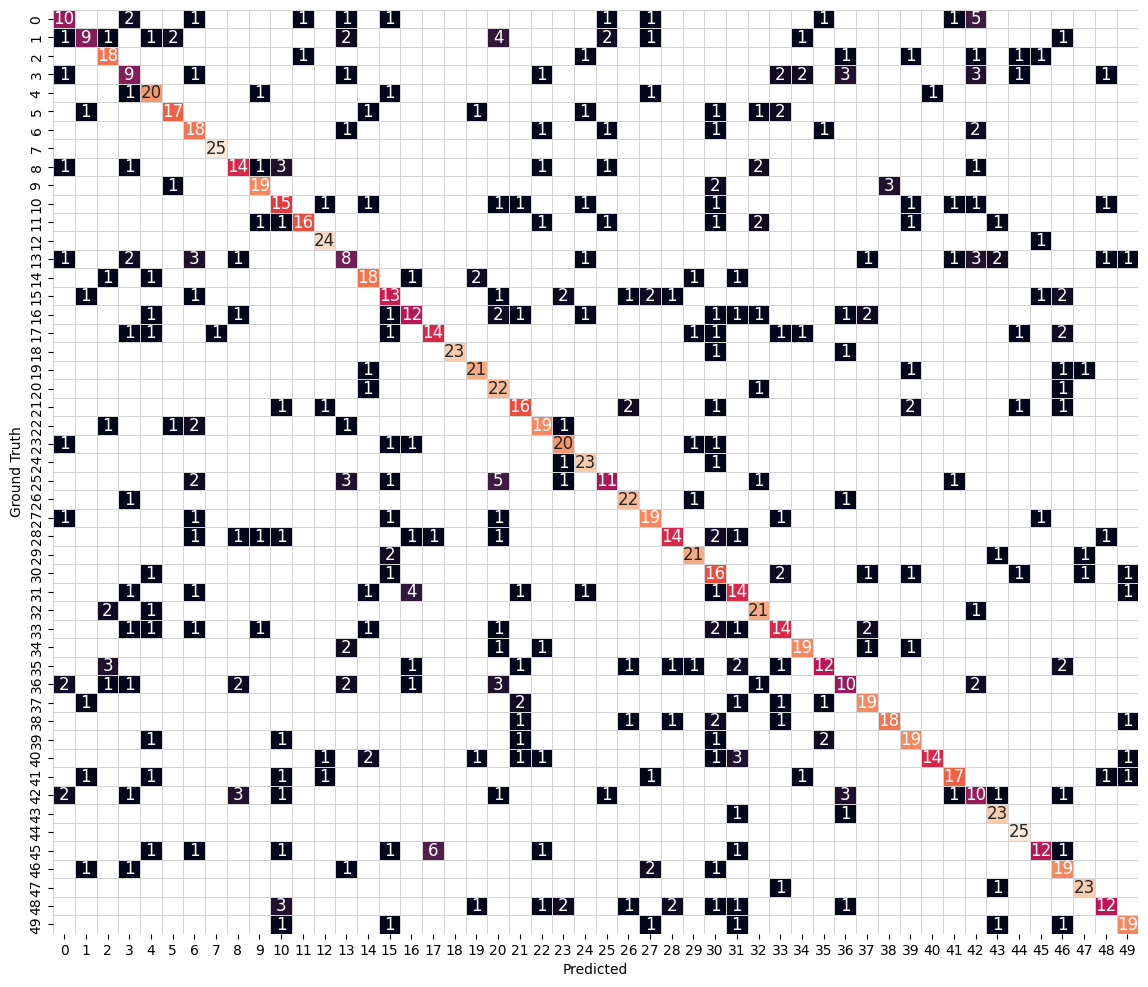

In [17]:
from src.helpers import plot_confusion_matrix

plot_confusion_matrix(pred, truth)